In [128]:

import numpy as np
import pickle
import json

task="ag_news"
model_name="lstm"
serialization_dir = f'outputs/{task}/{model_name}'

# modifications
with open(f'{serialization_dir}/modifications_history.pickle', 'rb') as file:
    modifications_history = pickle.load(file)
iterations = list(modifications_history.keys())
print("Modifications are generated at the following iterations:", iterations)

# labels
labels = []
texts = []
with open(f'{serialization_dir}//train_modifications_0.json', "r") as data_file:
    
    for line in data_file.readlines():
        if not line:
            continue
        items = json.loads(line)
        text = items['text']
        texts.append(text)
        label = int(items.get('label'))
        labels.append(label)


Modifications are generated at the following iterations: [0, 30, 60]


In [130]:
def get_label_wise_bow_with_term_freq1(words, labels):
    """ 
    # Return
    word_sets_by_labels : a dictionary keyed by words, valued by {label1: count1, ...}
    """
    bow_with_term_freq = dict()
    
    for i, w in enumerate(words):

        # word_counts_by_labels
        label = labels[i]
        if w not in list(bow_with_term_freq.keys()):
            bow_with_term_freq[w] = {label: 1} # create a inner dict
        elif label not in list(bow_with_term_freq[w].keys()):
            bow_with_term_freq[w][label] = 1 # add new element to inner dict
        else:
            bow_with_term_freq[w][label] += 1 # count +
        
    return bow_with_term_freq

def get_words_freq(words, prob=False):
    
    word_freq_dict = dict()
    for w in words:
        try:
            word_freq_dict[w] += 1
        except KeyError:
            word_freq_dict[w] = 1
    # sort descendingly
    
    sorted_word_freq =  sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True)
    
    if prob:
        total_num = len(words)
        sorted_word_freq = [ (k, v/total_num) for k, v in sorted_word_freq ]
    return sorted_word_freq


def get_label_wise_bow(words, labels):
    """ 
    # Return
    word_sets_by_labels : a dictionary keyed by labels, valued by word sets
    """
    bow_by_labels = dict()
    for ref_label in set(labels):
        indices = [i for i, instance_lbl in enumerate(labels) if instance_lbl == ref_label]
        bow_by_labels[ref_label] = set([w for i, w in enumerate(words) if i in indices])
    return bow_by_labels

def get_average_jaccard_sim(unique_labels, word_sets_by_labels):
    
    average_jaccard_sim = 0
    total = 0
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            # jaccard 
            label1 = unique_labels[i]
            label2 = unique_labels[j]
            set1 = set(word_sets_by_labels[label1])
            set2 = set(word_sets_by_labels[label2])
            jaccard_sim = len(set1&set2)/ len(set1 | set2)
            average_jaccard_sim += jaccard_sim
            total += 1

    return average_jaccard_sim / total

# Calculate Average Jaccard Similarity
label_wise_bow_all_iter = {}
for i in iterations:
    words = [list(batch_modifications.values())[0] for batch_modifications in modifications_history[i]]
    label_wise_bow_all_iter[i] = get_label_wise_bow(words, labels)
unique_labels = list(set(labels))   
print(get_average_jaccard_sim(unique_labels, label_wise_bow_all_iter[30]) ) 
# ag_news: 0: 0; 30: 0.08; 60: 0.12
# sst2: 0:0; 30: 0.35

# cumulative probabilities for top N substitute words
N = 5
bow_with_term_freq_all_iter = dict()
for i in iterations:
    words = [list(batch_modifications.values())[0] for batch_modifications in modifications_history[i]]
   
    bow_with_term_freq = dict()  # a dictionary keyed by labels, valued by {word1: count1, ...}
    for ref_label in set(labels):
        indices = [i for i, instance_lbl in enumerate(labels) if instance_lbl == ref_label]
        words_for_label = [w for i, w in enumerate(words) if i in indices]
        bow_with_term_freq[ref_label] = get_words_freq(words_for_label, prob=True)
    
    bow_with_term_freq_all_iter[i] = bow_with_term_freq
print( bow_with_term_freq_all_iter[30])
for label in labels:
    print(round(sum([prob for w, prob in bow_with_term_freq_all_iter[60][label][:N]]), 2))

0.07898441427853192
{1: [('semifinal', 0.3811944091486658), ('Shiite', 0.1588310038119441), ('militias', 0.15756035578144853), ('Sufa', 0.11435832274459974), ('playoff', 0.07115628970775095), ('MSBlast', 0.0698856416772554), ('bombardments', 0.029224904701397714), ('Janjaweed', 0.007623888182973317), ('industries', 0.0038119440914866584), ('Antigay', 0.0025412960609911056), ('MyDoom', 0.0012706480304955528), ('Azamiyah', 0.0012706480304955528), ('civilians', 0.0012706480304955528)], 2: [('playoff', 1.0)], 3: [('billion', 0.9702072538860104), ('industries', 0.02849740932642487), ('utilities', 0.0012953367875647669)], 4: [('Browser', 0.4434782608695652), ('viruses', 0.2819875776397516), ('industries', 0.08198757763975155), ('4x400', 0.06832298136645963), ('software', 0.034782608695652174), ('explorer', 0.016149068322981366), ('MyDoom', 0.014906832298136646), ('utilities', 0.013664596273291925), ('browsers', 0.012422360248447204), ('Viruses', 0.009937888198757764), ('malware', 0.007453416

1.0
0.9
0.92
0.92
0.92
0.92
0.96
0.92
0.96
0.92
1.0
1.0
0.96
0.96
0.92
1.0
0.96
0.92
1.0
0.9
0.96
0.9
0.92
0.96
0.9
0.96
0.96
0.92
0.9
0.9
0.96
0.92
0.9
0.9
1.0
0.9
0.92
0.9
0.9
0.92
0.92
0.9
1.0
0.96
0.9
1.0
0.9
0.9
1.0
0.92
0.9
1.0
0.9
0.92
0.92
0.92
0.9
0.96
1.0
0.96
0.96
0.9
0.92
0.92
1.0
0.96
0.92
0.92
1.0
0.96
0.96
1.0
0.9
1.0
1.0
1.0
0.92
0.96
0.9
0.92
0.9
0.92
1.0
0.92
0.96
0.96
1.0
0.96
1.0
0.9
0.9
0.96
0.96
1.0
0.9
0.9
0.9
0.9
0.9
0.92
1.0
1.0
1.0
0.9
1.0
0.96
0.9
1.0
0.96
0.92
0.9
0.92
0.96
0.96
0.96
0.92
1.0
0.92
1.0
0.9
0.92
0.96
0.9
0.92
1.0
1.0
0.92
0.92
1.0
1.0
0.9
0.96
0.9
1.0
0.9
0.9
0.9
0.9
0.92
0.92
0.92
0.96
0.92
1.0
0.96
0.9
0.92
0.9
0.96
0.9
0.92
0.9
0.96
1.0
0.96
1.0
0.9
0.9
0.92
0.9
0.92
0.9
1.0
0.96
0.9
0.96
1.0
0.9
0.92
0.9
0.96
0.92
0.9
0.96
0.9
0.92
0.96
0.96
0.92
0.92
1.0
0.9
0.92
0.9
0.9
0.9
0.9
0.92
0.96
1.0
1.0
0.92
1.0
0.96
1.0
0.92
0.92
0.96
0.92
1.0
0.9
0.96
0.96
0.9
0.96
0.92
0.9
1.0
1.0
0.92
0.9
0.9
0.96
1.0
0.96
0.9
1.0
0.92
0.9
1.0
0.92
0.92
0.92

In [36]:



lst_index_from_last = []
lst_relative_position = []
for idx in range(100):

    modification =  [(k, v) for k, v in modifications[idx].items()]
    where_to_modify, what_to_modify = modification[0]
    index_from_last = len(instances[idx].fields['tokens'])- int(where_to_modify)
    relative_posistion = int(where_to_modify) / len(instances[idx].fields['tokens'])

    lst_index_from_last.append(index_from_last)
    lst_relative_position.append(relative_posistion)
    # print(instances[idx].fields['tokens'])
    # print(instances[idx].fields['label'])


In [50]:

np.unique(lst_index_from_last, return_counts=True)

(array([2, 3]), array([ 7, 93]))

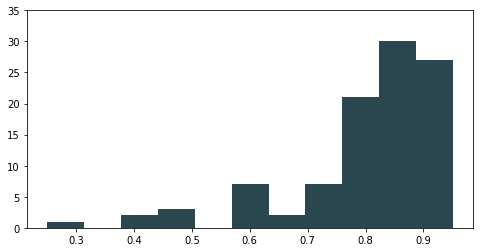

In [45]:

from matplotlib import pyplot as plt

# relative position
dt_hex = "#2b4750"
r_hex = "#dc2624"
fig = plt.figure(figsize= (8, 4))
plt.hist(lst_relative_position, color=dt_hex, bins=11)
plt.ylim((0,35))
plt.show()

### Effectiveness of Error-Min Modifications

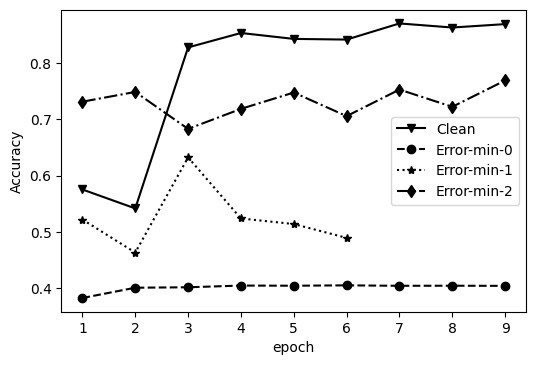

In [1]:
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# sst2-acc
# result = {
#     'BERT': {2: 1-0.68, 3: 1-0.65, 4: 1-0.62}, 
#     'RoBERTa': {1:1-0.76, 2:1-0.74, 3:1-0.71},
#     'ALBERT': { 2:1-0.72, 3:1-0.69, 4: 1-0.66}
#     }

file = "outputs/ag_news-lstm-test-acc.csv"
df = pd.read_csv(file)

if "test-acc" in file:
    df['epoch'] = df['epoch'] +1
    x_var = "epoch"
elif "norm" in file:
    x_var = "Step"
if file == "outputs/ag_news-lstm-test-acc.csv":
    df = df[df['epoch'] <10] 
result = df.to_dict(orient='list')


fig = plt.figure( figsize=(6, 4), dpi=100 )
ax = fig.add_subplot(1,1,1)


ax.plot(result[x_var], result['Clean'], color='black', linewidth=1.5, linestyle='-', marker='v', label='Clean')
ax.plot(result[x_var], result['Error-min-0'], color='black', linewidth=1.5, linestyle='--', marker='o', label='Error-min-0')
ax.plot(result[x_var], result['Error-min-30'], color='black', linewidth=1.5, linestyle=':', marker='*', label='Error-min-1')
ax.plot(result[x_var], result['Error-min-60'], color='black', linewidth=1.5, linestyle='-.', marker='d', label='Error-min-2')
# plt.xticks(np.linspace(1, 5, 5))
# plt.yticks(np.linspace(0, 0.4, 5))
# ax.set_ylim(0,0.5)
ax.set_xlabel(x_var)
ax.set_ylabel('Accuracy')
plt.legend(loc='best', frameon=True)
plt.show()
# ax.set_ylim(0,5)
# ax.set_ylim(0.6,0.93)


## Twitter Gender

In [ ]:
from allennlp_extra.data.dataset_readers import TwitterGenderDatasetReader, PerturbLabeledTextDatasetReadere
from allennlp.models import load_archive
archive = load_archive('../models/twitter_gender/bert/model.tar.gz')
model = archive.model
dataset_reader = archive.dataset_reader
instance_generator = dataset_reader.read(file_path="../data/squad/add_unlearn_substitution_random_pos.json")

import numpy as np
instance_generator = dataset_reader.read(file_path="../data/squad/remove_surround_words.json")
for instance in instance_generator:
    dataset_reader.apply_token_indexers(instance)
    output = model.forward_on_instance(instance)